In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [3]:
tf_dataset=tf.keras.utils.image_dataset_from_directory(
    "tomatoraw",
    shuffle=True,
    image_size=(256,256),
    batch_size=64
)

Found 11399 files belonging to 8 classes.
Metal device set to: Apple M1


In [4]:
class_names=tf_dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
def get_ds_partition(ds,train_split=0.8,test_split=0.10,val_split=0.10,shuffle = True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    ds_size=len(ds)
    train_size=int(train_split * ds_size)
    test_size=int(test_split * ds_size)
    #val_size=int(val_split * ds_size)
    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size).take(test_size)
    val_ds=ds.skip(train_size).skip(test_size)
    return train_ds,test_ds,val_ds

In [6]:
train_ds,test_ds,val_ds = get_ds_partition(tf_dataset)
len(train_ds),len(test_ds),len(val_ds)

(143, 17, 19)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)
])

In [9]:
data_argumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8
model=models.Sequential([
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(15,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10


2023-05-04 23:11:37.484438: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


143/143 [==============================] - 114s 742ms/step - loss: 1.8924 - accuracy: 0.2706 - val_loss: 1.9515 - val_accuracy: 0.3529
Epoch 2/10
143/143 [==============================] - 100s 699ms/step - loss: 1.3734 - accuracy: 0.5512 - val_loss: 2.3499 - val_accuracy: 0.3408
Epoch 3/10
143/143 [==============================] - 95s 667ms/step - loss: 1.0076 - accuracy: 0.6497 - val_loss: 0.9774 - val_accuracy: 0.6695
Epoch 4/10
143/143 [==============================] - 95s 667ms/step - loss: 0.7780 - accuracy: 0.7311 - val_loss: 1.0866 - val_accuracy: 0.6713
Epoch 5/10
143/143 [==============================] - 98s 682ms/step - loss: 0.6824 - accuracy: 0.7557 - val_loss: 1.2858 - val_accuracy: 0.6575
Epoch 6/10
143/143 [==============================] - 97s 679ms/step - loss: 0.5592 - accuracy: 0.7959 - val_loss: 0.7389 - val_accuracy: 0.7645
Epoch 7/10
143/143 [==============================] - 98s 682ms/step - loss: 0.5105 - accuracy: 0.8130 - val_loss: 1.0442 - val_accuracy: 0

In [13]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


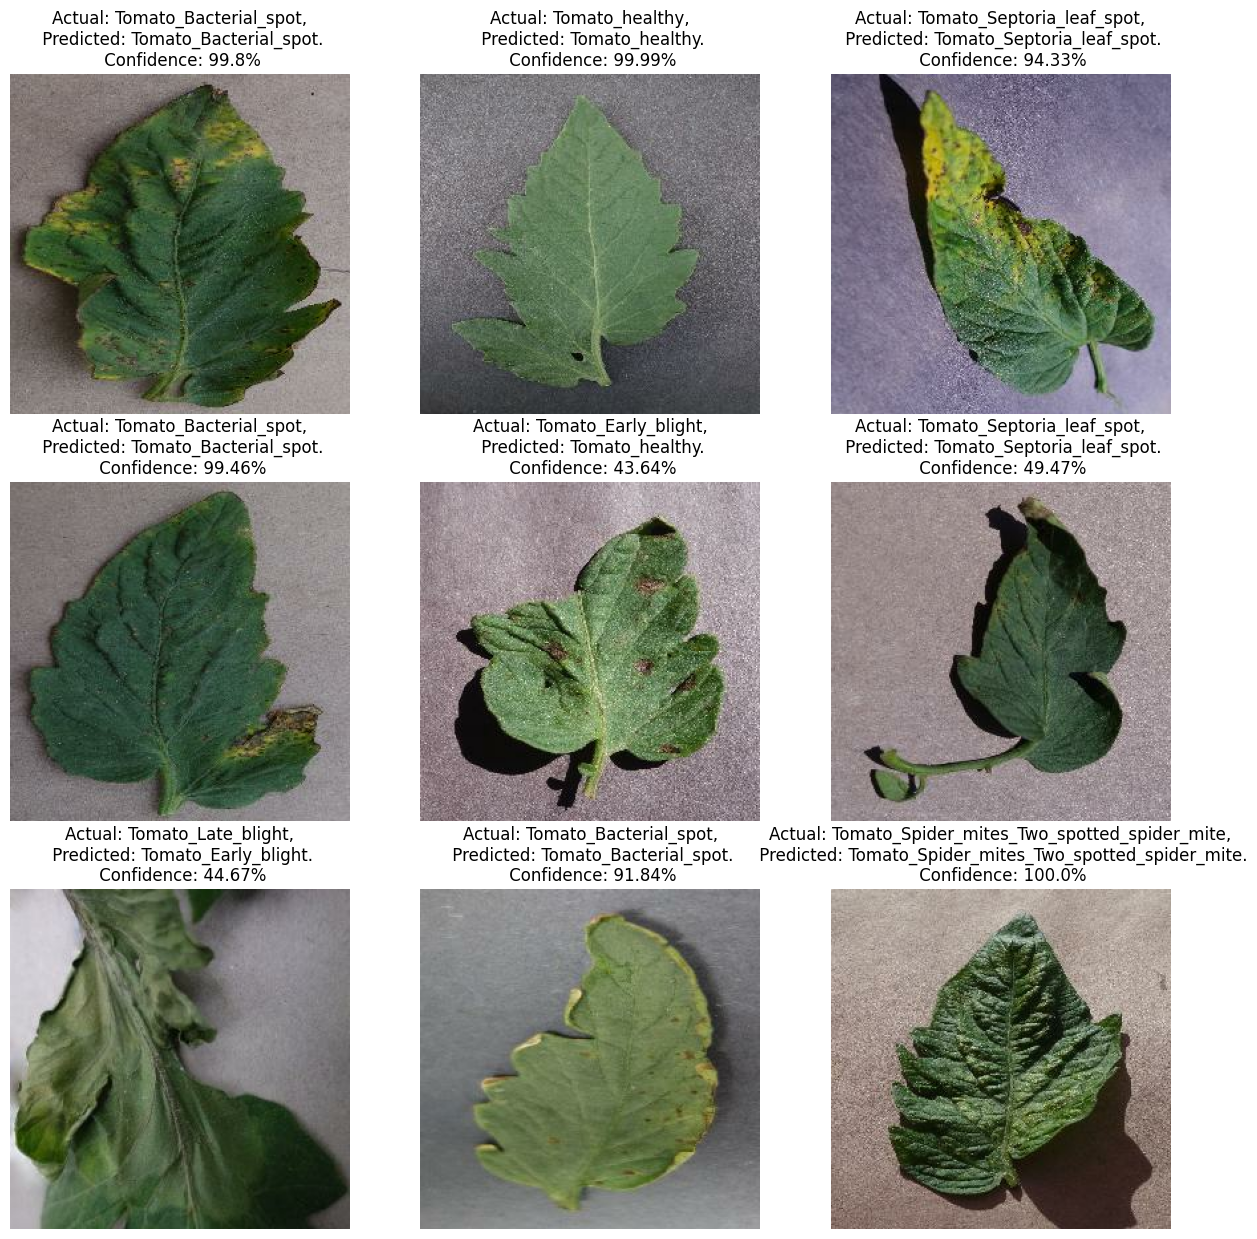

In [14]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [15]:
model.save("../model_version/tomato_model.h5",wb)

NameError: name 'wb' is not defined

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("../model_version/potato.tflite", 'wb') as f:
  f.write(tflite_model)